# Manual Phase Flip Graph Coloring Oracle and Grover's Search (Three Nodes, 2 Edges)

In [152]:
import warnings
warnings.filterwarnings("ignore")

## Initialize Problem Statement

In [153]:
num_vertices = 3
edges_list = [(0, 1), (1, 2)]

num_edges = len(edges_list)
num_qubits = (2 * num_vertices) + num_edges + 1

possible_solutions = ["100001000", "100100010"]

In [154]:
print(f"Number of Vertices: {num_vertices}")
print(f"Number of Edges: {num_edges}")
print(f"Edges List: {edges_list}\n")

print(f"Number of Qubits: {num_qubits}")
print(f"Possible Solutions: {possible_solutions}")

Number of Vertices: 3
Number of Edges: 2
Edges List: [(0, 1), (1, 2)]

Number of Qubits: 9
Possible Solutions: ['100001000', '100100010']


### Visualize Graph

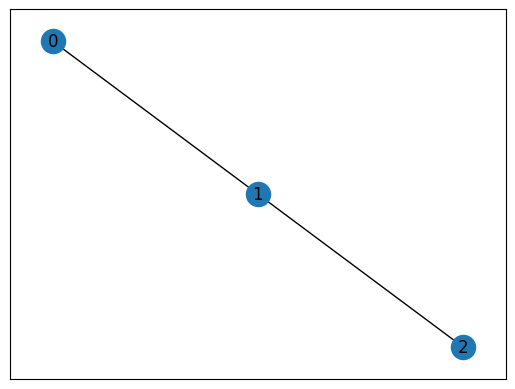

In [155]:
import networkx as nx
from networkx import Graph

def display_graph(num_vertices: int, edges_list: list[tuple[int]]) -> None:
    G = Graph()

    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges_list)

    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

display_graph(num_vertices=num_vertices, edges_list=edges_list)

## Manual Flip Oracle

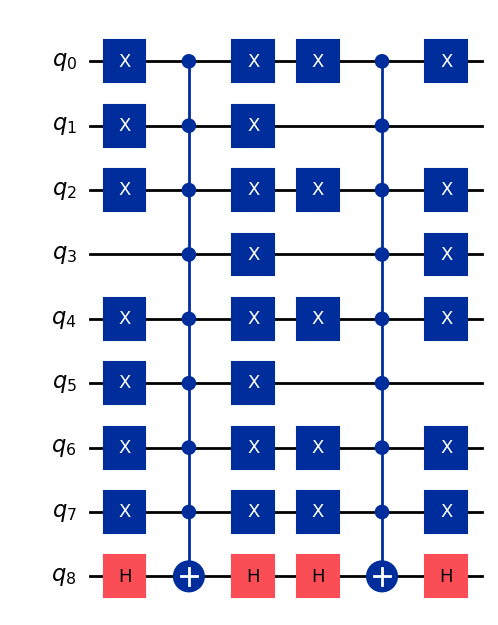

In [156]:
from qiskit import QuantumCircuit

def grover_oracle(num_qubits: int, marked_states: list[str]) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    for marked_state in marked_states:
        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                circuit.x(i)

        circuit.h(num_qubits - 1)
        circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        circuit.h(num_qubits - 1)

        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                circuit.x(i)

    return circuit

grover_oracle(num_qubits=num_qubits,
              marked_states=possible_solutions).draw("mpl")

### Test Oracle Circuit (Input State)

#### Positive Test Case

In [157]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("100001000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [158]:
test_circuit = grover_oracle(num_qubits=num_qubits,
                             marked_states=possible_solutions)


test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Negative Test Case

In [159]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("100101000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [160]:
test_circuit = grover_oracle(num_qubits=num_qubits,
                             marked_states=possible_solutions)


test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

### Test Oracle Circuit (Super-Position States)

In [161]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

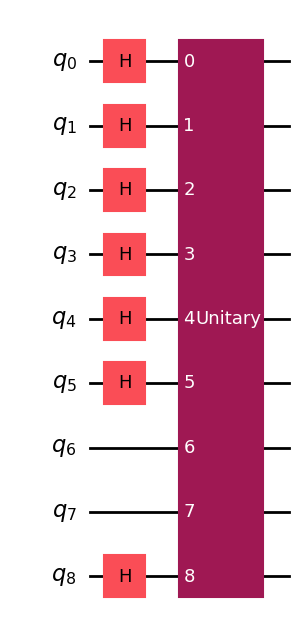

In [162]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

test_circuit = QuantumCircuit(num_qubits)
test_circuit.h([0, 1, 2, 3, 4, 5, 8])

oracle_operator = Operator(grover_oracle(num_qubits=num_qubits,
                       marked_states=possible_solutions))

test_circuit.append(oracle_operator, list(range(num_qubits)))
test_circuit.draw("mpl")

In [163]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

In [164]:
import numpy as np

print(np.real(test_vector_output[int("100001000", 2)]))
print(np.real(test_vector_output[int("100101000", 2)]))

-0.08838834764831636
0.0883883476483165


## Ristricting State Space of the Three Node for Two Colors

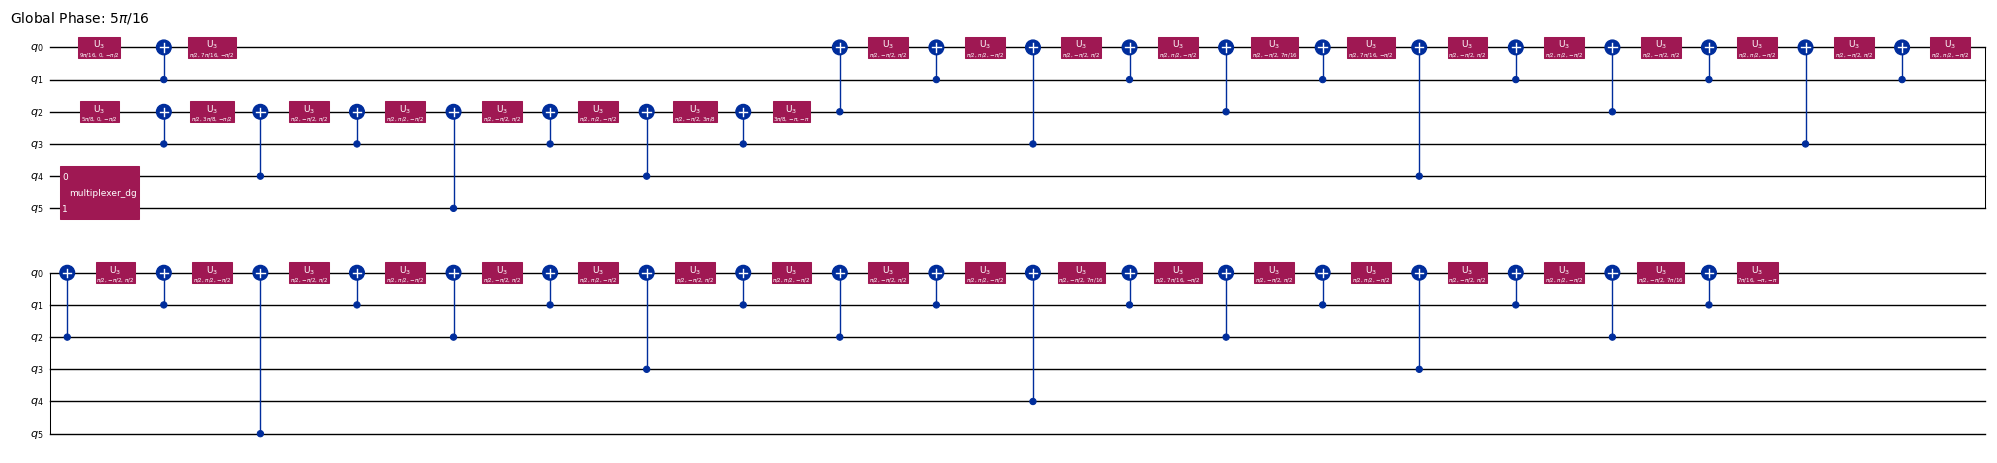

In [165]:
from itertools import product
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import textwrap

def circuit_initializer(num_qubits: int, restrict_states: list[str]) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    bin_seq = ["".join(seq) for seq in product("01", repeat=num_qubits)]
    bin_seq = list(map(lambda x: textwrap.wrap(x, 2), bin_seq))

    allowed_states = [state for state in bin_seq if not any(rs in state for rs in restrict_states)]
    allowed_states = list(map(lambda x: "".join(x), allowed_states))

    amplitude = len(allowed_states)
    bin_seq = list(map(lambda x: "".join(x), bin_seq))

    state_vec_amplitudes = [1 / np.sqrt(amplitude) if state in allowed_states else 0 for state in bin_seq]
    psi_0 = Statevector(state_vec_amplitudes)

    if psi_0.is_valid():
        circuit.initialize(psi_0)

    circuit = transpile(circuit)
    circuit.data = [inst for inst in circuit.data if inst.operation.name != "reset"]

    return circuit

circuit_initializer(num_qubits=6, restrict_states=["11", "10"]).draw("mpl", scale=0.5, vertical_compression="high", fold=60)

### Test Circuit Initializer

In [166]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

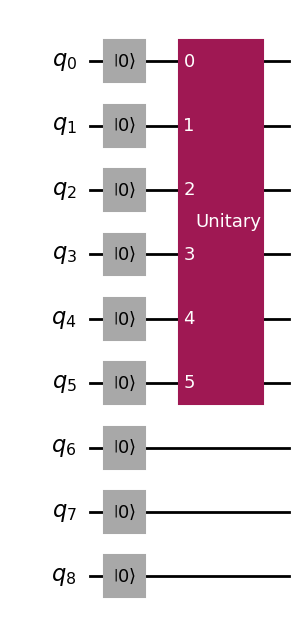

In [167]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

test_circuit = QuantumCircuit(num_qubits)
test_circuit.reset(list(range(num_qubits)))

circuit_init_operator = Operator(circuit_initializer(num_qubits=(num_vertices * 2),
                                   restrict_states=["11", "01"]))

test_circuit.append(instruction=circuit_init_operator,
                    qargs=list(range(2 * num_vertices)))

test_circuit.draw("mpl")

In [168]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Check if the state is Entangled

In [169]:
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy

def is_entangled(state: Statevector, epsilon: float=1e-10) -> bool:
    num_qubits = state.num_qubits
    density_matrix = DensityMatrix(state)

    for qubit in range(num_qubits):
        trace_out = [i for i in range(num_qubits) if i != qubit]
        reduced_dm = partial_trace(density_matrix, trace_out)

        subsystem_entropy = entropy(reduced_dm)

        if subsystem_entropy > epsilon:
            return True

    return False

In [170]:
is_entangled(state=test_vector_output)

False

### Unitary Tests for Circuit Initializer

In [171]:
circuit_init_operator.draw("latex")

<IPython.core.display.Latex object>

In [172]:
circuit_init_operator_dag = circuit_init_operator.transpose().conjugate()
circuit_init_operator_dag.draw("latex")

<IPython.core.display.Latex object>

In [173]:
print(circuit_init_operator.is_unitary())

True


In [174]:
Operator(circuit_init_operator @ circuit_init_operator_dag).draw("latex")

<IPython.core.display.Latex object>

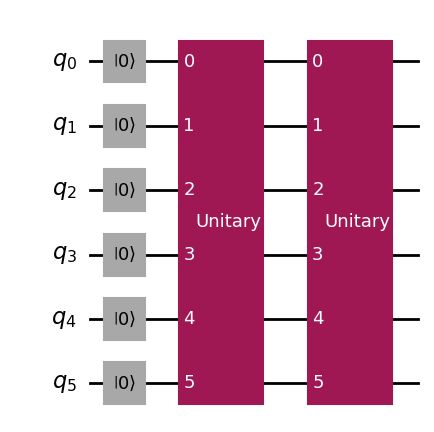

In [175]:
from qiskit import QuantumCircuit

test_circuit = QuantumCircuit(6)
test_circuit.reset(list(range(6)))

test_circuit.append(circuit_init_operator, list(range(6)))
test_circuit.append(circuit_init_operator_dag, list(range(6)))

test_circuit.draw("mpl")

In [176]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [177]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

### Test Circuit Initializer with H Gate to Output Qubit

In [178]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

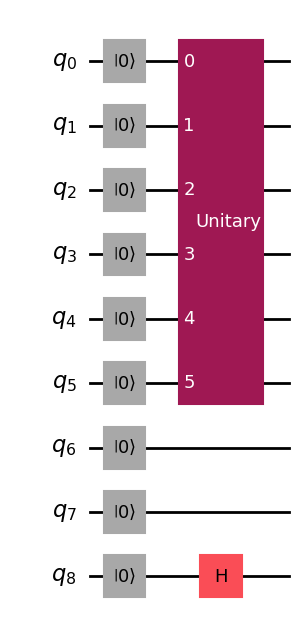

In [179]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

test_circuit = QuantumCircuit(num_qubits)
test_circuit.reset(list(range(num_qubits)))

circuit_init_operator = Operator(circuit_initializer(num_qubits=(num_vertices * 2),
                                   restrict_states=["11", "01"]))

test_circuit.h(num_qubits - 1)
test_circuit.append(circuit_init_operator, list(range(2 * num_vertices)))

test_circuit.draw("mpl")

In [180]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Check if the state is Entangled

In [181]:
is_entangled(state=test_vector_output)

False

## Grover's Diffusion Operator

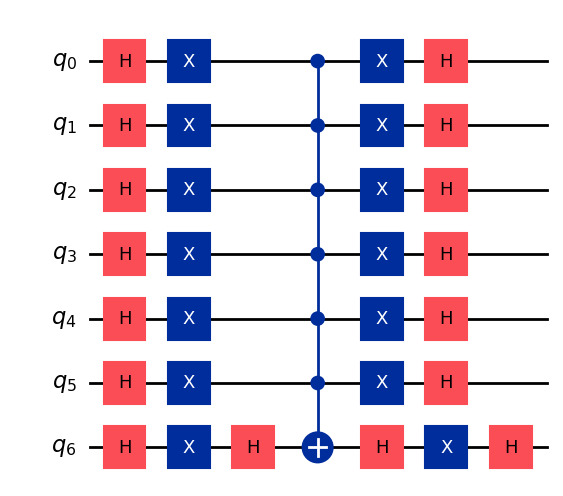

In [182]:
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

def diffusion_operator(num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    circuit.h(list(range(num_qubits)))
    circuit.x(list(range(num_qubits)))

    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)

    circuit.x(list(range(num_qubits)))
    circuit.h(list(range(num_qubits)))

    circuit.append(Operator(GlobalPhaseGate(phase=np.pi)))

    return circuit

diffusion_operator(num_qubits=((2 * num_vertices) + 1)).draw("mpl")

### Test Diffusion Operator on Random States Space

In [183]:
from qiskit.quantum_info import Statevector
import numpy as np

N = 3
size = 2

random_negative_idx = list(set(np.sort(np.random.randint(low=0, high=(2 ** N) - 1, size=size)).tolist()))
print(random_negative_idx)

test_vector_input = np.array(Statevector.from_label("+" * N))
test_vector_input[random_negative_idx] *= -1

test_vector_input = Statevector(test_vector_input)
test_vector_input.draw("latex")

[0, 5]


<IPython.core.display.Latex object>

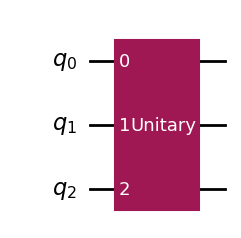

In [184]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

diffusion_op = Operator(diffusion_operator(num_qubits=N))

test_circuit = QuantumCircuit(N)
test_circuit.append(diffusion_op, list(range(N)))

test_circuit.draw("mpl")

In [185]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

## Number of Iterations (If more than One Solution)

In [186]:
def get_num_iter(num_qubits: int, num_solutions: int = None) -> int:
    if num_solutions is None:
        num_solutions = 1

    return int(np.floor((np.pi / 4) * np.sqrt((2 ** num_qubits) / num_solutions)))

## Simulation Function

In [187]:
from qiskit import transpile, QuantumCircuit
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

def simulate(circuit: QuantumCircuit, num_shots: int = 1024, display_circuit: bool = False) -> None:
    circuit.measure_all(add_bits=False)

    backend = AerSimulator()
    circuit = transpile(circuit, backend=backend)

    if display_circuit:
        display(circuit.draw("mpl"))

    counts = backend.run(circuit, shots=num_shots).result().get_counts()
    display(plot_histogram(counts, figsize=(15, 8)))

## Apply Grover Search on Problem (With all states space)

### One Iteration

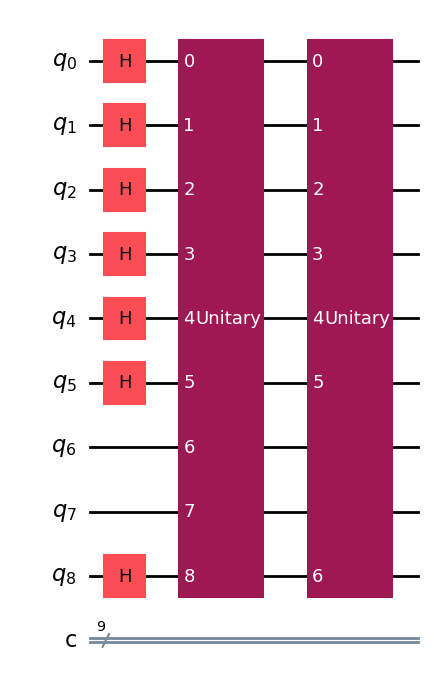

In [188]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

oracle_operator = Operator(grover_oracle(num_qubits=num_qubits,
                                         marked_states=possible_solutions))
diffusion_op = Operator(diffusion_operator(num_qubits=(num_qubits - num_edges)))

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:2 * num_vertices])
circuit.h(q_regs[-1])

circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, [0, 1, 2, 3, 4, 5, 8])

circuit.draw("mpl")

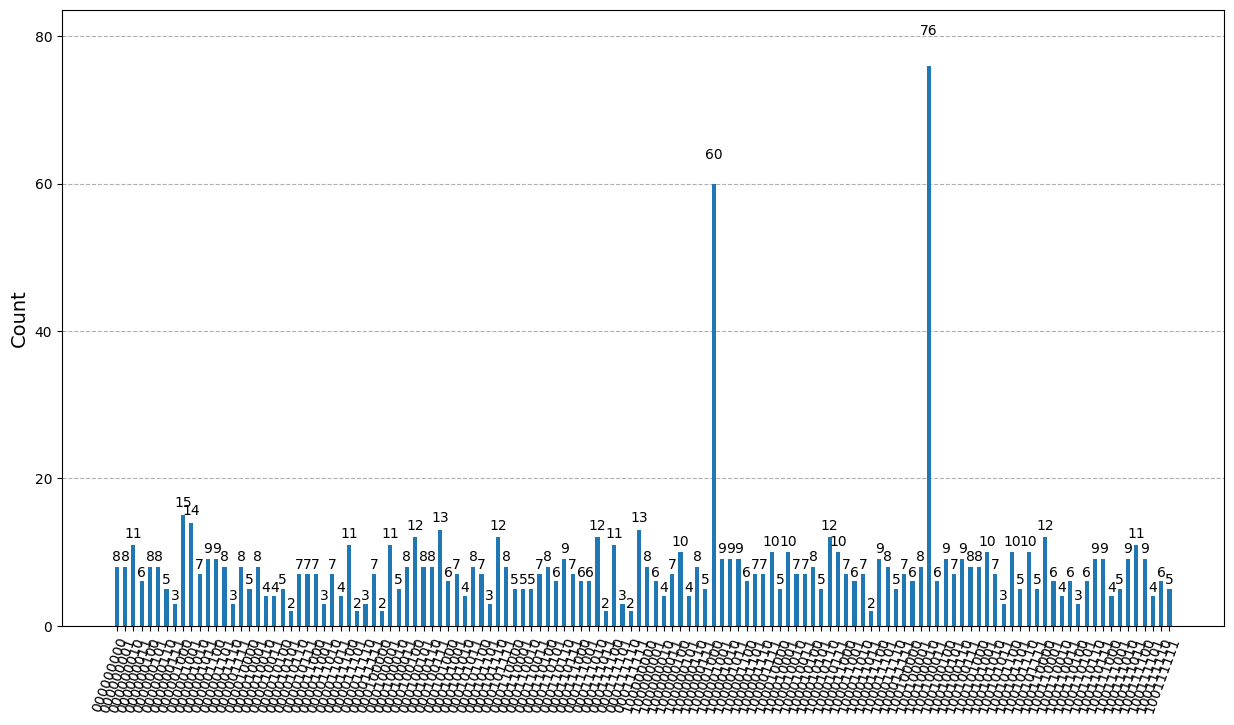

In [189]:
simulate(circuit=circuit)

### Using Number of Iterations

In [190]:
num_iter = get_num_iter(num_qubits=(num_qubits - num_edges), num_solutions=len(possible_solutions))
print(num_iter)

6


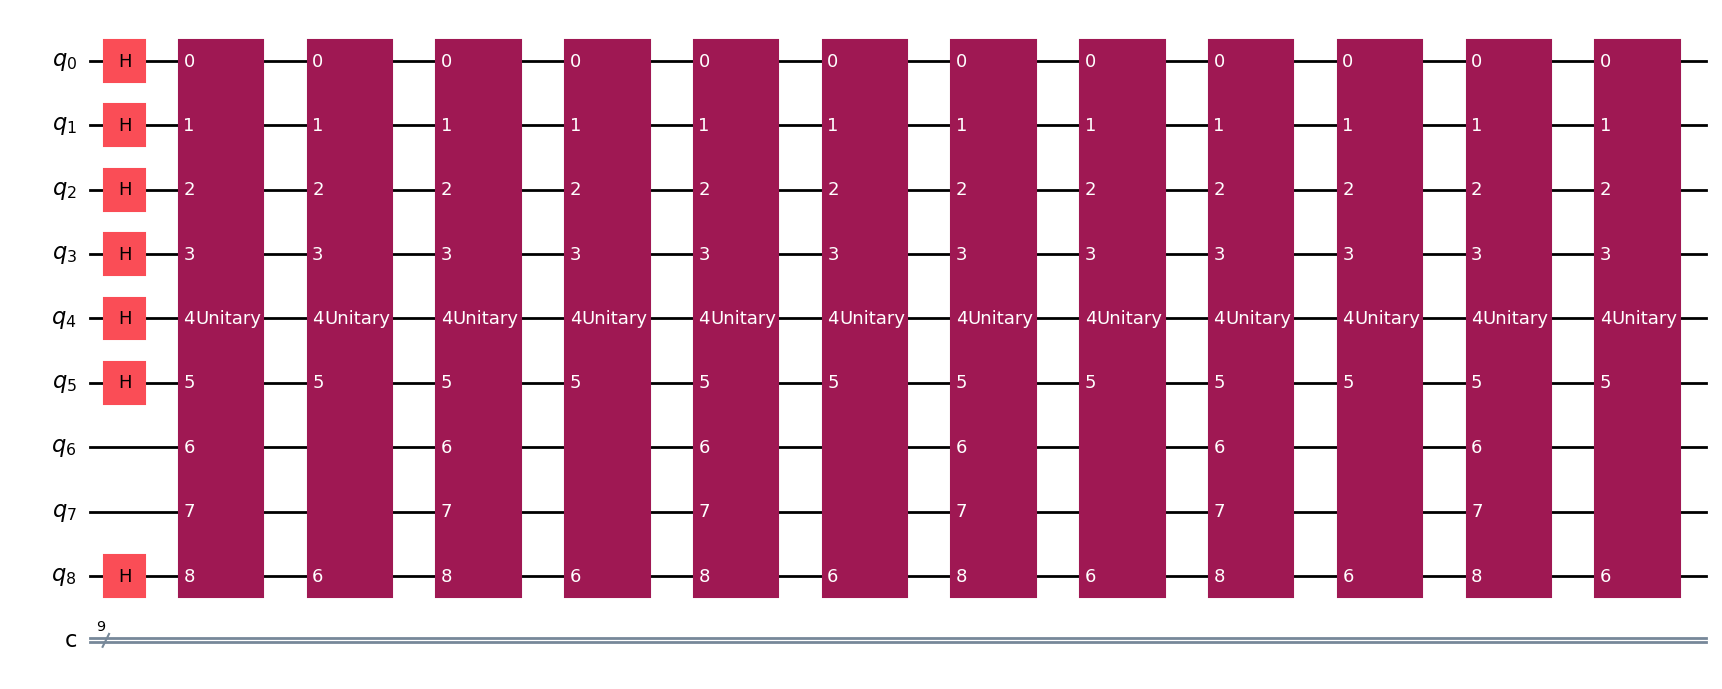

In [191]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

oracle_operator = Operator(grover_oracle(num_qubits=num_qubits,
                                         marked_states=possible_solutions))
diffusion_op = Operator(diffusion_operator(num_qubits=(num_qubits - num_edges)))

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:2 * num_vertices])
circuit.h(q_regs[-1])

for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_op, [0, 1, 2, 3, 4, 5, 8])

circuit.draw("mpl")

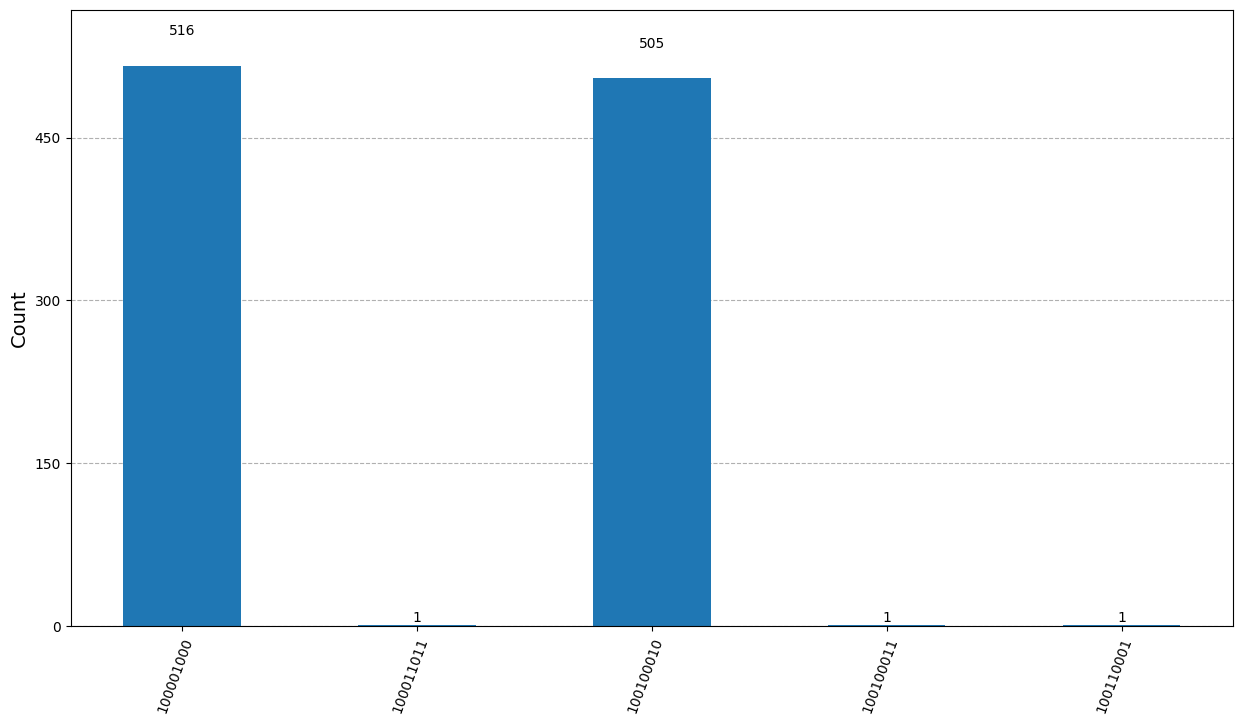

In [192]:
simulate(circuit=circuit)

## Apply Grover Search on Problem (With restricted states space)

### Test Oracle on Ristricted State Space

In [193]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

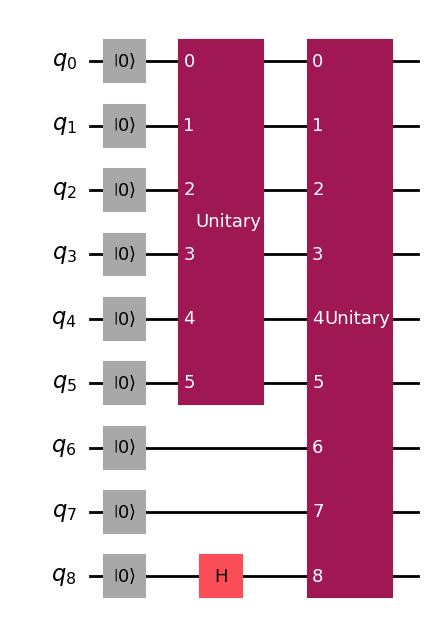

In [194]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))
circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

oracle_operator = Operator(grover_oracle(num_qubits=num_qubits,
                                         marked_states=possible_solutions))

q_regs = QuantumRegister(num_qubits, name='q')

test_circuit = QuantumCircuit(q_regs)
test_circuit.reset(q_regs)

test_circuit.append(circuit_init_gate, q_regs[:(2 * num_vertices)])
test_circuit.h(q_regs[-1])

test_circuit.append(oracle_operator, q_regs)

test_circuit.draw("mpl")

In [195]:
test_vector_output = test_vector_input.evolve(test_circuit)

print(is_entangled(test_vector_output))
test_vector_output.draw("latex")

True


<IPython.core.display.Latex object>

In [196]:
import numpy as np

print(np.real(test_vector_output[int("100001000", 2)]))
print(np.real(test_vector_output[int("100101000", 2)]))

-0.2499999999999946
0.24999999999999498


### Test with Custom Diffusion Operator (One Iteration)

In [202]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

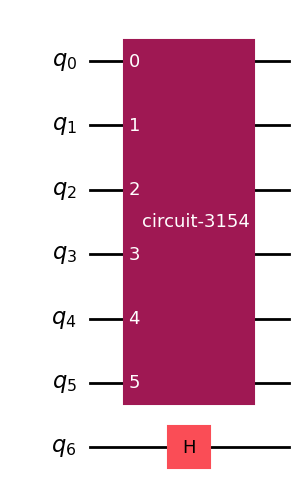

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [203]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from IPython.display import display

op_circuit = QuantumCircuit(((2 * num_vertices) + 1))

circuit_init = circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate()

op_circuit.append(circuit_init, list(range(2 * num_vertices)))
op_circuit.h(-1)

display(op_circuit.draw("mpl"))

test_vector_input_dop = Statevector.from_instruction(op_circuit)

display(test_vector_input_dop.draw("latex"))

test_outer = Operator((2 * np.outer(test_vector_input_dop, test_vector_input_dop)) - np.eye(128, 128))
test_outer.draw("latex")

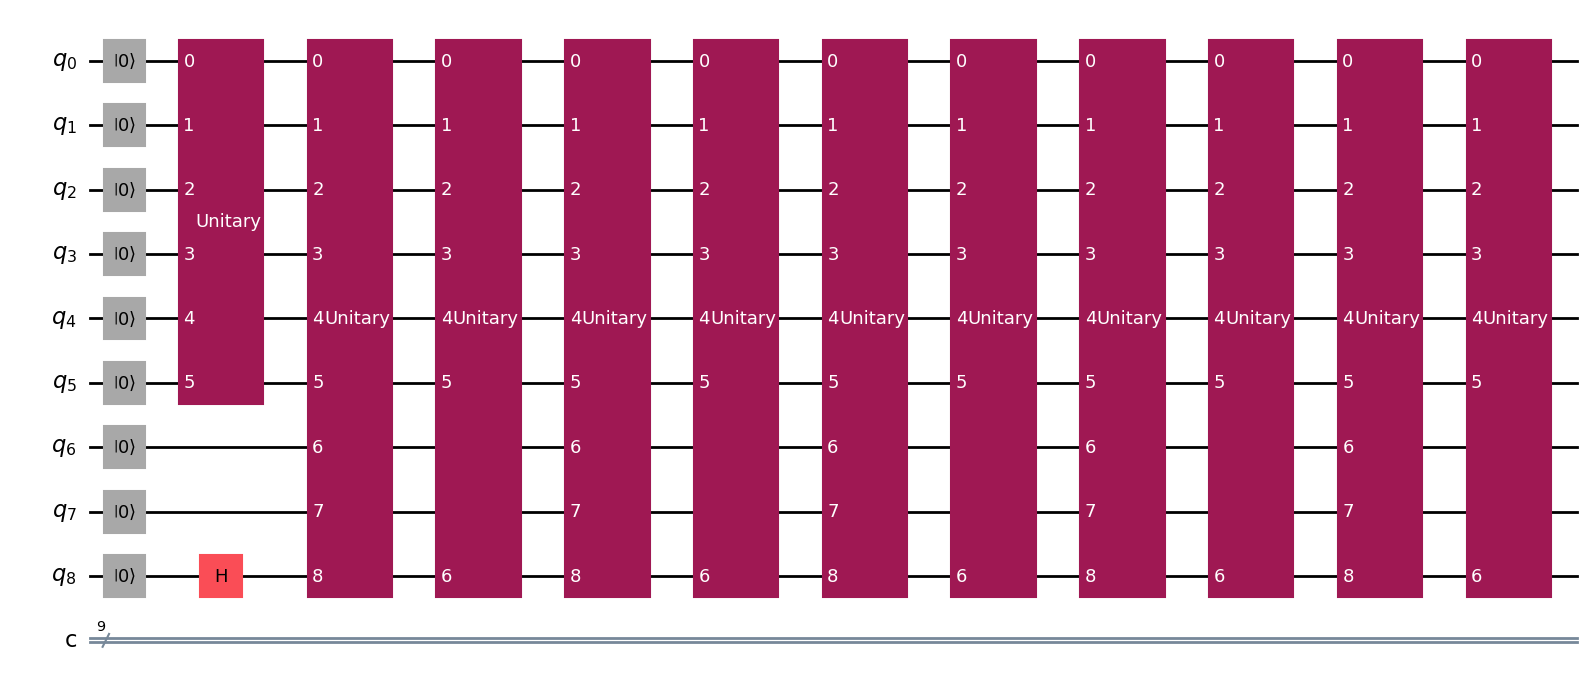

In [204]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

test_circuit = QuantumCircuit(q_regs, c_regs)
test_circuit.reset(q_regs)

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))

circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

oracle_operator = Operator(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions))

test_circuit.append(circuit_init_gate, q_regs[:(2 * num_vertices)])
test_circuit.h(q_regs[-1])

for _ in range(num_iter - 1):
    test_circuit.append(oracle_operator, q_regs)
    test_circuit.append(test_outer, [0, 1, 2, 3, 4, 5, 8])

test_circuit.draw("mpl")

In [205]:
test_vector_output = test_vector_input.evolve(test_circuit)

print(is_entangled(test_vector_output))
test_vector_output.draw("latex")

True


<IPython.core.display.Latex object>

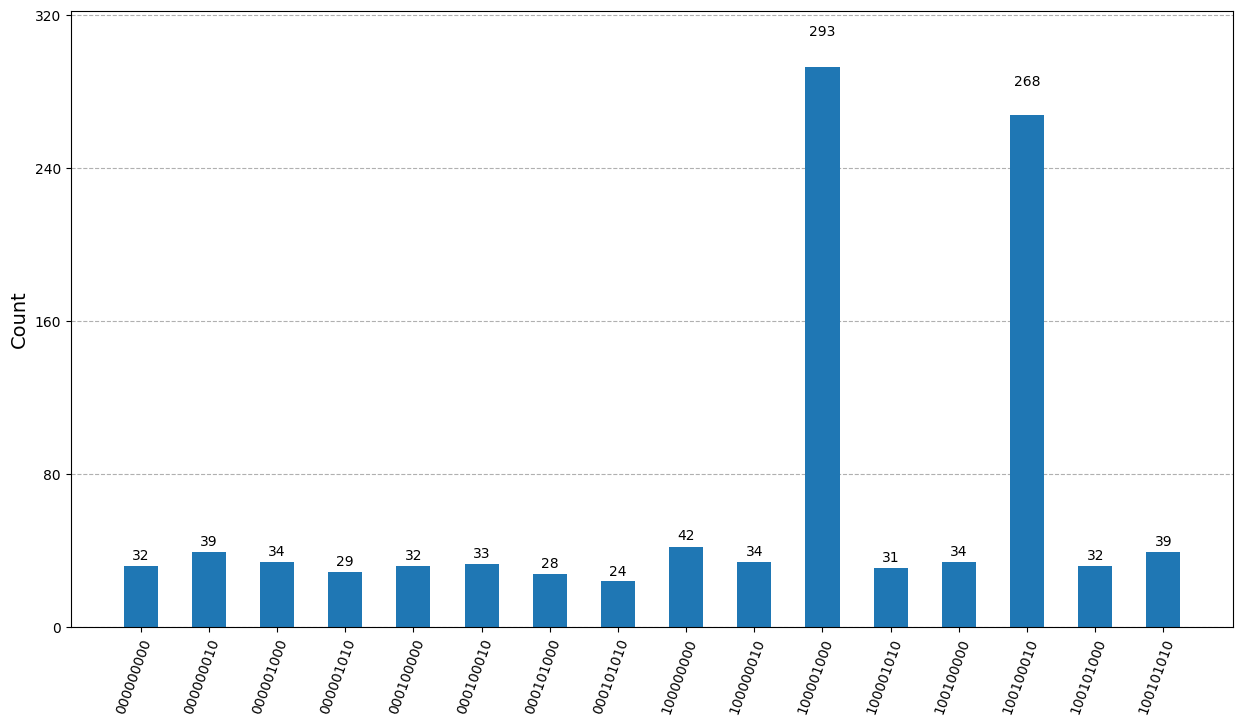

In [206]:
simulate(circuit=test_circuit)